In [219]:
%load_ext autoreload
%autoreload 2
import os
import sys
import numpy as np
from scipy import stats

base_dir = '/Users/simon/git/ms1fun/'
sys.path.append(base_dir + 'code')
sys.path.append(base_dir + 'dbs')

from corr_cluster import Peak,BetaLike,CorrCluster
from formula import Formula
import pylab as plt
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Grab some std1 files

In [220]:
prefix = '/Users/simon/Dropbox/BioResearch/Meta_clustering/StandardData140606/csv/'
files = [f.split('.')[0] for f in os.listdir(prefix) if f.endswith('.csv') and 'Std_1' in f]
print files
filename = files[0]

['batch1_Std_1_1', 'batch1_Std_1_2', 'batch2_Std_1_1', 'batch2_Std_1_2', 'batch3_Std_1_1', 'batch3_Std_1_2', 'batch4_Std_1_1', 'batch4_Std_1_2']


In [289]:
prefix = '/Users/simon/Downloads/Beer3_mzXML_mzML_files/PositiveMode/Beer3Full/csv/'
filename = 'Beer_3_Full1'

In [290]:

bl = BetaLike()
print "Running file " + filename
csvfile = prefix + filename + '.csv'
matfile = prefix + filename + '.corr.mat'
signalfile = prefix + filename + '.peakml.signal'
coc = CorrCluster(bl,csvfile,matfile,signal_file=signalfile,greedy_thresh=0.7,correct=True)

Running file Beer_3_Full1
1421.38000488
Loaded 7863 peaks
Reading shape correlations from /Users/simon/Downloads/Beer3_mzXML_mzML_files/PositiveMode/Beer3Full/csv/Beer_3_Full1.corr.mat
Greedy clustering done, resulting in 1116 clusters


In [291]:
import transformation
transformations = transformation.load_from_file(base_dir + 'dbs/pos_transformations_reduced.yml')
print "Loaded " + str(len(transformations)) + " transformations"

Loaded 54 transformations


Transform a cluster and see what we get

In [293]:
def print_cluster(cluster):
    plt.figure()
    for peak in cluster.members:
        plt.plot([peak.mass,peak.mass],[0,peak.intensity],'r')

Bin the masses into nominal (integer bins)

In [294]:
PROTON = 1.00727645199076


class Mol(object):
    def __init__(self,name,formula,mass,rt):
        self.name = name.strip()
        self.formula = formula.strip()
        self.mass = mass
        self.rt = rt
    def __str__(self):
        return "{} ({},{})".format(self.name,self.mass,self.rt)
    def __repr__(self):
        return "{} ({},{})".format(self.name,self.mass,self.rt)

Load the standards database from file

In [295]:
std_file = base_dir + 'dbs/std1_20130822_130526.csv'
mols = []
with open(std_file,'rU') as f:
    for i in range(9):
        f.readline() # remove heads
    for line in f:
        split_line = line.split(',')
        polarity = split_line[4]
        rt = float(split_line[8])
        if polarity == '+' and rt > 0.0:
            name = split_line[2]
            formula = split_line[3]
            rt = float(split_line[8])
            f = Formula(formula)
            new_mol = Mol(name,formula,f.compute_exact_mass(),rt*60.0)
            mols.append(new_mol)
mols = sorted(mols,key = lambda x: x.mass)

Find the protonated transformation for baselining

In [296]:
protonated = [t for t in transformations if t.name=='M+H'][0]

Functions for matching peaks to a database

In [297]:
def hit(m1,m2,rt1,rt2,mtol=20,rttol=1):
    if 1e6*np.abs(m1-m2)/m2 < mtol and np.abs(rt1-rt2)<rttol:
        return True
    else:
        return False
    
def get_hits(peaks,mols,transformations,mtol=20,rttol = 120.0):
    hits = {}
    for mol in mols:
        for peak in peaks:
            for t in transformations:
                if hit(t.transform(peak),mol.mass,peak.rt,mol.rt,mtol = mtol,rttol = rttol):
                    if mol in hits:
                        if np.abs(peak.rt - mol.rt) < np.abs(hits[mol].rt - mol.rt):
                            hits[mol] = peak
                    else:
                        hits[mol] = peak
    return hits

In [298]:
def plot_peaks(peaks,log=False):
    plt.figure()
    for p in peaks:
        if log:
            plt.semilogy([p.mass,p.mass],[0,p.intensity],'r')
        else:
            plt.plot([p.mass,p.mass],[0,p.intensity],'r')

Find the hits in the data - plot the predicted v actual rt for sanity checking

{Guanine (151.049409809,725.4): <corr_cluster.Peak object at 0x1167a1150>, Pyridoxine (169.073893225,454.8): <corr_cluster.Peak object at 0x10d360f90>, L-Leucine (131.094628667,625.8): <corr_cluster.Peak object at 0x10c6d2ad0>, Melatonin (232.121177769,279.0): <corr_cluster.Peak object at 0x10d208450>, L-Phenylalanine (165.078978603,585.6): <corr_cluster.Peak object at 0x1167794d0>, L-Tryptophan (204.08987764,682.8): <corr_cluster.Peak object at 0x10a79be10>, Inosine (268.080769517,638.4): <corr_cluster.Peak object at 0x10c68ce90>, Serotonin (176.094963018,257.4): <corr_cluster.Peak object at 0x10d2d8750>, Creatinine (113.058911863,563.4): <corr_cluster.Peak object at 0x10c6c70d0>, 2-Phenylglycine (151.063328539,649.2): <corr_cluster.Peak object at 0x10a619dd0>}


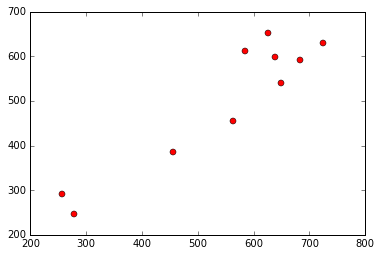

In [299]:
hits = get_hits(coc.peaks,mols,[protonated])
true = []
measured = []
for mol in hits:
    true.append(mol.rt)
    measured.append(hits[mol].rt)
plt.plot(true,measured,'ro')
print hits

Have a look at the cluster sizes

In [300]:
mol_sizes = []
for mol in hits:
    mol_sizes.append((mol.name,coc.Z[hits[mol]].size))

mol_sizes = sorted(mol_sizes,key=lambda x: x[1],reverse=True)
print mol_sizes

[('Melatonin', 152), ('Serotonin', 125), ('L-Tryptophan', 75), ('L-Phenylalanine', 57), ('Creatinine', 53), ('Pyridoxine', 51), ('L-Leucine', 44), ('Inosine', 38), ('Guanine', 35), ('2-Phenylglycine', 7)]


Look at an individual cluster and see what we can find

In [301]:
mi = [m for m in mols if m.name=='Phenylhydrazine'][0]
mip = hits[mi]
cluster = coc.Z[mip]
print "Cluster has {} members".format(len(cluster.members))
plot_peaks(cluster.members,log=False)
plot_peaks(cluster.members,log=False)
print mi.mass,mip.mass,mip.intensity
plt.xlim([mi.mass-30,mi.mass+30])

KeyError: Phenylhydrazine (108.068748268,306.0)

Perform the voting...

In [302]:
from voter import Voter,PeakGroup
v = Voter(transformations)
groups = []
for cluster in coc.clusters:
    groups += v.make_groups(cluster.members)

In [303]:
baseline_M = []
for p in coc.peaks:
    baseline_M.append((protonated.transform(p),1))
our_M = []
for g in groups:
    our_M.append((g.M,g.vote))
print len(baseline_M),len(our_M)

def get_M_hits(M_list,mols):
    hits = {}
    for m in M_list:
        for mol in mols:
            if hit(mol.mass,m[0],0,0,mtol=10,rttol=1):
                if not mol in hits:
                    hits[mol] = m[1]
                else:
                    if m[1] > hits[mol]:
                        hits[mol] = m[1]
                
    return hits
base = get_M_hits(baseline_M,mols)
our = get_M_hits(our_M,mols)
a = np.array(our.values())
# a = np.array([o[1] for o in our])
b = np.array([g.vote for g in groups])
print a.mean(),a.std()
print b.mean(),b.std()

print a

7863 5825
1.29615384615 0.550685425511
1.2109527897 0.557093902136
[ 2.85  1.    1.9   1.    1.    1.    1.2   1.    1.9   1.    1.    1.    1.  ]


Output a file with the groups (and peaks that form them)

In [305]:
# Sort the groups according to votes (top ones first)

outfile = 'Beer3Full1'

groups = sorted(groups,key = lambda x:x.vote,reverse=True)
outfile += '_by_vote.txt'
# groups = sorted(groups,key = lambda x:x.M)
# outfile += '_by_M.txt'
    

with open(outfile,'w') as f:
    for i,group in enumerate(groups):
        line = "vote: {}, M: {}\n".format(group.vote,group.M)
        f.write(line)
        head_line = '\tPeak m/z,Peak rt,Peak intensity,transformation (transformed mass,vote)\n'
        f.write(head_line)
        for (peak,transformation,transmass) in sorted(group.members,key = lambda x: x[1].vote,reverse=True):
            line = "\t{:.4f},{:.4f},{:.2e},{} ({:.4f},{})\n".format(peak.mass,peak.rt,peak.intensity,transformation,transmass,transformation.vote)
            f.write(line)
        f.write('\n')

In [238]:
def get_group_hits(group,mols):
    # Currently ignores RT
    avgM = 0.0
    for p in group.members:
        avgM += p[2]
    avgM /= len(group.members)
    hits = []
    for mol in mols:
        if hit(avgM,mol.mass,0,0,mtol=10,rttol=1):
            hits.append(mol)
    return hits

print mi.mass
for i,g in enumerate(groups):
    print "Group {}".format(i)
    total_vote = 0.0
    pe = []
    for m in g.members:
        pe.append(m[0])
        print m[2],m[1],m[0],'%.2E' % m[0].intensity,m[1].vote
    print g.vote,g.M,[h for h in get_group_hits(g,mols)]

108.068748268
Group 0
169.073952118 [M-H2O]+H (152.070663883, 428.455596924) 5.96E+07 0.5
169.073812836 M+H (170.081089288, 428.455596924) 2.17E+09 1.0
169.073746967 M+H[C13] (171.084378257, 428.455596924) 1.90E+08 0.9
169.073709244 [M-H2O]+ACN+H (193.096970112, 428.455596924) 1.15E+06 0.2
2.6 169.07381104 [Pyridoxine (169.073893225,454.8)]
Group 1
299.032990433 M+H (300.040266885, 429.676727295) 5.37E+05 1.0
1.0 299.032990433 []
Group 2
170.070965438 M+H (171.07824189, 429.676727295) 1.06E+07 1.0
1.0 170.070965438 []
Group 3
137.047485562 M+H (138.054762014, 427.23550415) 7.43E+05 1.0
1.0 137.047485562 [4-Aminobenzoate (137.047678474,634.2)]
Group 4
133.05280993 M+H (134.060086382, 423.571838379) 4.51E+06 1.0
1.0 133.05280993 []
Group 5
169.073948815 [M-H2O]+H (152.07066058, 423.571838379) 5.21E+07 0.5
169.073816091 M+H (170.081092543, 423.571838379) 2.00E+09 1.0
169.073780013 [M-H2O]+ACN+H (193.09704088, 423.571838379) 1.09E+06 0.2
1.7 169.073819435 [Pyridoxine (169.073893225,454.8)]

In [239]:
for m in mols:
    print (m.name,m.mass,m.rt)

('Glycine', 75.03202841014, 923.4000000000001)
('Putrescine', 88.10004839616, 1176.6)
('beta-Alanine', 89.04767847442, 901.1999999999999)
('Glycerol', 92.04734412342, 538.2)
('L-Serine', 105.04259309652, 931.1999999999999)
('Phenylhydrazine', 108.0687482676, 306.0)
('Creatinine', 113.0589118628, 563.4000000000001)
('L-Proline', 115.06332853869999, 742.8000000000001)
('Selenomethionine', 117.07897860297999, 660.6)
('L-Valine', 117.07897860297999, 725.4)
('L-2_4-Diaminobutanoate', 118.07422757608, 1187.3999999999999)
('L-Threonine', 119.0582431608, 846.5999999999999)
('Nicotinate', 123.03202841013999, 430.79999999999995)
('Taurine', 125.01466378651999, 886.1999999999999)
('Imidazole-4-acetate', 126.04292744752, 675.6)
('trans-4-Hydroxy-L-proline', 131.0582431608, 849.0)
('L-Leucine', 131.09462866726, 625.8)
('L-Asparagine', 132.0534921339, 898.8000000000001)
('L-Aspartate', 133.03750771862, 891.0)
('Adenine', 135.0544951869, 548.4000000000001)
('4-Aminobenzoate', 137.04767847442, 634.2)


Some redundant cells - probably to be chopped

In [240]:
a = [1,2,3]
b = [4,5,6]
print a+b

[1, 2, 3, 4, 5, 6]
